### 1. Load the dataset

**[1.1] Automatic reload modules**

In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**[1.2] Import packages**

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump

**[1.3] Load the datasets**

In [99]:
X_train = pd.read_csv('../data/processed/X_train.csv')
X_val   = pd.read_csv('../data/processed/X_val.csv')
X_test  = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_val   = pd.read_csv('../data/processed/y_val.csv')
y_test = pd.read_csv('../data/interim/y_test.csv')

In [100]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()

In [101]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(33001, 58)
(8251, 58)
(4970, 58)


### 2. Feature Engineering

**[2.1] Correlation**

In [102]:
features = X_train
corr_matrix = features.corr().round(2)
sign_corr_matrix = corr_matrix[(corr_matrix>=0.9) | (corr_matrix <=-0.9)]

import plotly.express as px
#Create correlation heatmap
fig = px.imshow(sign_corr_matrix, x=sign_corr_matrix.columns, y=sign_corr_matrix.columns,
                zmin=-1, zmax=1, color_continuous_scale='RdYlBu',title='Features correlation', text_auto=True)

#Update the layout
fig.update_xaxes(tickangle=45)
fig.show()

**[2.2] Feature Importance**

* Removing the least significant features from the last experiment

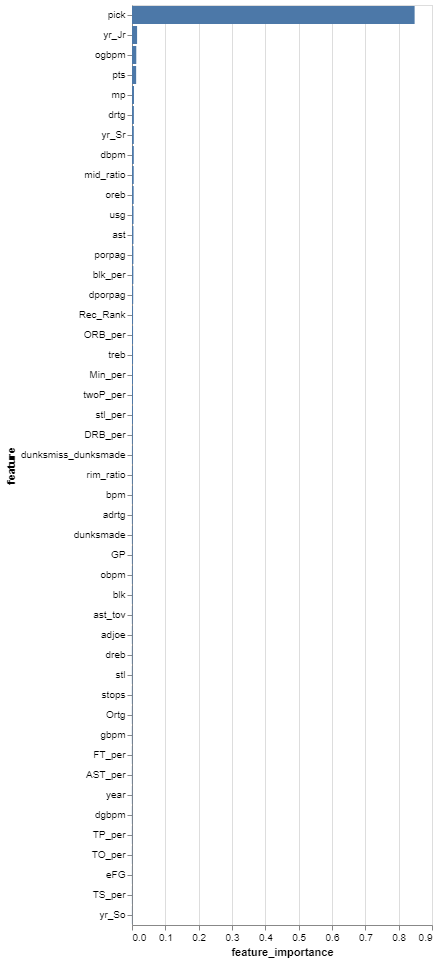

**Drop collinear and insignificant features**

In [103]:
to_drop = ['FTM', 'FTA', 'twoPM', 'twoPA', 'TPM', 'TPA', 'rimmade', 'rimmade_rimmiss',
          'midmade', 'midmade_midmiss', 'Picked', 'Recruited', 'TS_per', 'eFG']

In [104]:
X_train = X_train.drop(X_train[to_drop], axis=1)
X_val = X_val.drop(X_val[to_drop], axis=1)
X_test = X_test.drop(X_test[to_drop], axis=1)

X_train.columns

Index(['yr_Jr', 'yr_So', 'yr_Sr', 'GP', 'Min_per', 'Ortg', 'usg', 'ORB_per',
       'DRB_per', 'AST_per', 'TO_per', 'FT_per', 'twoP_per', 'TP_per',
       'blk_per', 'stl_per', 'porpag', 'adjoe', 'year', 'Rec_Rank', 'ast_tov',
       'rim_ratio', 'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'pick',
       'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm',
       'mp', 'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk',
       'pts'],
      dtype='object')

### 3. Train XGBoost Default Model - Hyperparameter Tuning with RandomSearchCV

**[3.1] Instantiate and fit the model**

In [105]:
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=8)

**[3.2] Parameters dictionary**

In [106]:
from scipy.stats import randint

param_ran = {
    'n_estimators': randint(1, 100),
    'gamma': randint(0, 10),
    'max_depth': randint(1, 10),
    'min_child_weight': randint(1, 10),
    'scale_pos_weight': randint(1, 100)
}

**[3.3] Instantiate and fit the hyperparameters wit Stratified KFold**

In [107]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)
ransearch = RandomizedSearchCV(xg, param_ran, cv=skf, random_state=8)

In [108]:
ransearch.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importanc...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002058B32E850>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002058B32C110>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002058B32F410>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002058B32CF90>},
                   random_state=8)

**[3.4] Display the best set of parameters**

In [109]:
ransearch.best_params_

{'gamma': 4,
 'max_depth': 9,
 'min_child_weight': 7,
 'n_estimators': 92,
 'scale_pos_weight': 69}

**[3.5] Evaluation metrics for hyperparameters**

In [110]:
ransearch.best_score_

np.float64(0.9946971395518585)

In [111]:
print("RanCV_Train:", f'{ransearch.score(X_train, y_train):.4f}')
print("RanCV_val:", f'{ransearch.score(X_val, y_val):.4f}')

RanCV_Train: 0.9975
RanCV_val: 0.9953


**[3.6] Make prediction on training data**

In [112]:
y_train_pred = ransearch.best_estimator_.predict_proba(X_train)[:, 1]
y_val_pred = ransearch.best_estimator_.predict_proba(X_val)[:, 1]

**[3.7] Performance metric - AUROC**

In [113]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [114]:
print("Train - AUROC:\n", f'{roc_auc_score(y_train, y_train_pred):.4f}')
print("Val - AUROC:\n", f'{roc_auc_score(y_val, y_val_pred):.4f}')

Train - AUROC:
 0.9999
Val - AUROC:
 0.9982


**Plot the AUROC curve**

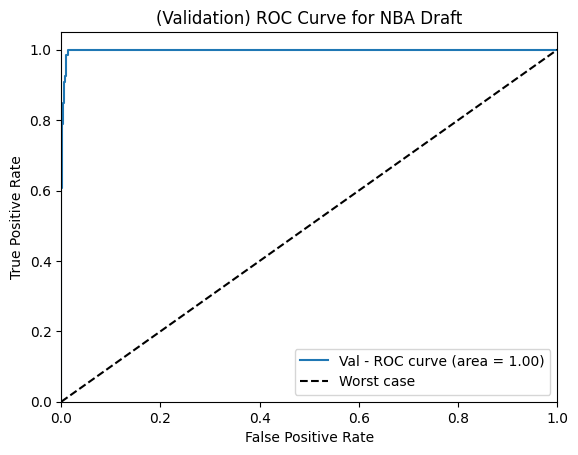

In [115]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred) 
roc_auc = auc(fpr, tpr)
plt.figure()  
plt.plot(fpr, tpr, label='Val - ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Worst case')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(Validation) ROC Curve for NBA Draft')
plt.legend()
plt.show()

**[3.8] Predict on test data**

In [116]:
y_test_pred = ransearch.best_estimator_.predict_proba(X_test)[:, 1]

#Dataframe for pred result
y_pred = y_test
y_pred.loc[:, 'drafted'] = y_test_pred

print(y_pred.describe().round(5))

y_pred = pd.DataFrame(y_pred)

#Save the result to CSV file
y_pred.to_csv('../data/external/at1_pred_week3.7.csv', index=False)

          drafted
count  4970.00000
mean      0.00668
std       0.07594
min       0.00005
25%       0.00008
50%       0.00008
75%       0.00010
max       0.99827


### 4. Feature Importance

In [117]:
feature = ransearch.best_estimator_.feature_importances_

In [118]:
#Dataframe of feature importance
feat_imp_rf_df = pd.DataFrame(
    {'feature': X_train.columns,
     'feature_importance': feature})

In [119]:
#Sort the dataframe
feat_imp_rf_df = feat_imp_rf_df.sort_values('feature_importance', ascending=False).reset_index(drop=True)
feat_imp_rf_df

,feature,feature_importance
0,pick,0.828646
1,dreb,0.012544
2,mp,0.011265
3,pts,0.011144
4,porpag,0.006496
5,ogbpm,0.006424
6,usg,0.006351
7,adjoe,0.005419
8,DRB_per,0.005343
9,dporpag,0.005313


In [120]:
#Visualize the feature importance
import altair as alt

alt.Chart(feat_imp_rf_df).mark_bar().encode(
    x='feature_importance',
    y=alt.Y("feature", sort='-x'),
    tooltip=['feature','feature_importance']
)

alt.Chart(...)